In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import sys
import os
import random
import glob
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import PIL.ImageOps 
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader, Dataset

use_gpu = torch.cuda.is_available()

In [3]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  
    print('Using GPU')
else:
    device = torch.device("cpu")  
    print('Using CPU')


Using CPU


In [9]:
DATA_DIR = "E:/desktop/Monsoon Sem/ECNN/focus&unfocus7/"
trn_dir = f'{DATA_DIR}/train'
tst_dir = f'{DATA_DIR}/test'

sz = 64
batch_size = 64

In [ ]:
# images = [f for f in glob(f'{trn_dir}/*/*.jpg')]   # training images
 

# num_images = len(images)
# avg_width, avg_height = 0.0, 0.0
# for img_fname in tqdm(images, desc='Gathering statistics'):
#     w, h = Image.open(img_fname).size
#     avg_width += w
#     avg_height += h
    
# avg_width /= num_images
# avg_height /= num_images

# print('Average width: {:.2f}, Average height: {:.2f}'.format(avg_width, avg_height))


In [ ]:
# mean = np.array([0., 0., 0.])
# std = np.array([0., 0., 0.])

# for img_fname in tqdm(images, desc='Gathering statistics'):
#     img = np.array(Image.open(img_fname).convert('RGB'))
#     mean += np.mean(img, axis=(0, 1))
#     std += np.std(img, axis=(0, 1))

# mean /= num_images
# std /= num_images

# print('Mean:', mean / 255.0)
# print('Std:', std / 255.0)

In [10]:
os.listdir(DATA_DIR)

['test', 'train']

In [ ]:
# os.listdir(test_dir)

In [11]:
trn_fnames = glob(f'{trn_dir}/*/*.tif')
trn_fnames[:3]

['E:/desktop/Monsoon Sem/ECNN/focus&unfocus7//train\\focus_unfocus\\sharp_blur_ver1_80875.tif',
 'E:/desktop/Monsoon Sem/ECNN/focus&unfocus7//train\\focus_unfocus\\sharp_blur_ver1_80876.tif',
 'E:/desktop/Monsoon Sem/ECNN/focus&unfocus7//train\\focus_unfocus\\sharp_blur_ver1_80877.tif']

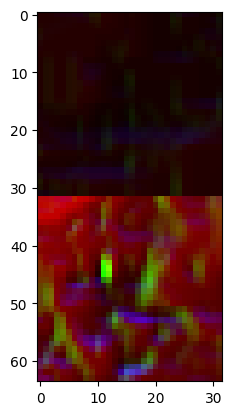

In [12]:
img = plt.imread(trn_fnames[100])
plt.imshow(img);

In [13]:
train_ds = datasets.ImageFolder(trn_dir)

In [14]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz//2)),  # PIL Image
#     transforms.Grayscale(), 
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.44 , 0.053, 0.062], [0.076, 0.079, 0.085])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
test_ds = datasets.ImageFolder(tst_dir, transform=tfms)


In [15]:
len(train_ds),  len(test_ds)

(22500, 15000)

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=8)

In [17]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
# imshow(out, title='Random images from training data')

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

In [18]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        
        self.conv3_3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
                
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   
           
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128*2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   

        self.fc1 = nn.Linear(256*8*4*2, 2)

        
        
    def forward(self, x, y, z):
        outx = self.conv1_1(x)
        outx = self.conv2_1(outx)
        outx = self.conv3_1(outx)
        outx = self.conv4(outx)
        outx = outx.view(outx.size(0), -1)
        
        outy = self.conv1_2(y)
        outy = self.conv2_2(outy)
        outy = self.conv3_2(outy)

        
        outz = self.conv1_3(z)
        outz = self.conv2_3(outz)
        outz = self.conv3_3(outz)
        
        oyz=torch.cat([outy,outz],1)
        
        oyz = self.conv5(oyz)
        oyz = oyz.view(oyz.size(0), -1)
                
        oo=torch.cat([outx,oyz],1)
             
        out = self.fc1(oo)
           
        return out

In [19]:
model = CNN()

if (use_gpu):
    
    model = model.cuda()
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [20]:
model

CNN(
  (conv1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_2): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_3): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool

In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [22]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [23]:
a = time.time()
num_epochs = 1
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        

        
        inputs = to_var(inputs)
#         inputs2 = to_var(inputs2)
#         inputs3 = to_var(inputs3)
        targets = to_var(targets)
        
        inputs1=inputs[:,0,:,:]
        inputs1=inputs1.resize(inputs1.shape[0],1,64,32)
        inputs2=inputs[:,1,:,:]
        inputs2=inputs1.resize(inputs2.shape[0],1,64,32)
        inputs3=inputs[:,2,:,:]
        inputs3=inputs1.resize(inputs3.shape[0],1,64,32)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs1,inputs2,inputs3)

        # loss
        loss = criterion(outputs, targets)
        losses += [loss.item()]


        # backward pass
        loss.backward()

        
        # update parameters
        optimizer.step()

        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))
            
b = time.time()
print('Total Time of Training {:.1000}s'.format(b - a))

c:\Users\av413\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch [ 1/ 1], Step [ 50/351], Loss: 0.2492
Epoch [ 1/ 1], Step [100/351], Loss: 0.1467
Epoch [ 1/ 1], Step [150/351], Loss: 0.3367
Epoch [ 1/ 1], Step [200/351], Loss: 0.1879
Epoch [ 1/ 1], Step [250/351], Loss: 0.2555
Epoch [ 1/ 1], Step [300/351], Loss: 0.0942
Epoch [ 1/ 1], Step [350/351], Loss: 0.1711
Total Time of Training 1794.170647144317626953125s


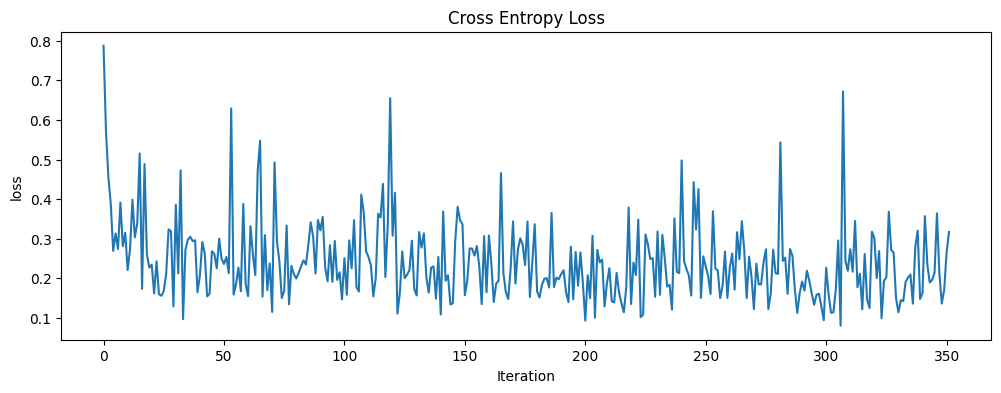

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

In [25]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
#         targets = to_var(targets)
        
        inputs1=inputs[:,0,:,:]
        inputs1=inputs1.resize(inputs1.shape[0],1,64,32)
        inputs2=inputs[:,1,:,:]
        inputs2=inputs1.resize(inputs2.shape[0],1,64,32)
        inputs3=inputs[:,2,:,:]
        inputs3=inputs1.resize(inputs3.shape[0],1,64,32)
        
        outputs = model(inputs1,inputs2,inputs3)
        _, preds = torch.max(outputs.data, 1) 
        corrects += (preds == targets.data).sum()
        
    zz=len(dataloader.dataset)
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    print('corrects: {:.2f}'.format(corrects))
    print('Toatal: {:.2f}'.format(zz))
    

In [26]:
evaluate_model(model, train_dl)

KeyboardInterrupt: 

In [ ]:
evaluate_model(model, test_dl)

C:\Users\av413\AppData\Local\Temp\ipykernel_16548\2390227020.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 98.71
corrects: 47003.00
Toatal: 47618.00


In [27]:
torch.save(model.state_dict(), 'trained_final_ntw.pth')